# 0.0. IMPORTS

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import math
import datetime

from IPython.display import Image

sns.set_style( 'darkgrid' )
sns.set_palette( 'Paired' ) 

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DESCRIÇÃO DOS DADOS

In [3]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [5]:
print( 'Number of Rows: {}' .format( df1.shape[0] ) )
print( 'Number of Rows: {}' .format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Rows: 18


## 1.3. Data Types

In [6]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

   1. **Competition_distance** (distance in meters to the nearest competitor store):
       - I assume that, if there's NA, the store doesn't have a competition or the competitor are so far that can't be consired a competitor.
       - Approach: Put a distance much far than the max distance in this feature.
       

   2. **Competition_open_since_month** (gives the approximate month of the time the nearest competitor was opened):
   
   There are at least two situations that explain why this columns are empty: 
       - **A**. The store doesn't have a near competitor. And then, there isn't an open date to competition.
       - **B**. The store has a competitor, but it's no known when it opened.
           - Might be because the competitor opend before the store open or it was opened after and wasn't registered.
       - Approach: It'll be filled to the month value from the date column.
       
       
   3. **Competition_open_since_year** (gives the approximate year of the time the nearest competitor was opened)
   
   The same approach as before, but now it'll be filled with the year.
   

   4. **promo2_since_week and promo2_since_year** (describes the year and calendar week when the store started participating in Promo2)
       - If it is NA, it means that the stores decided not to continue with the promo2, so this information has not been available "since when", as it has not adopted it at any time.
       - Approach: It'll be filled by year and week values from the date column.
       
       
   5. **promo_interval** (describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store)
       
       - Approach: It'll be filled by 0, It means that the store is not between the interval of months that the promo2 started.
       
       
   6. **month_map** (new feature created)
       - It'll be filled by the month from the "date" column in string form (Jan, Feb, ..., Dec) to be compared with the "promo_interval" feature.
       
       
   7. **is_promo** (new feature created)
       - Receives 1 when the store has a promotion and 0 when it doesn't.
       - Approach: if the month in the "month_map" column is between the months "Feb,May,Aug,Nov" that are in the promo_interval column it returns 1, if not, it returns 0

In [8]:
df1['competition_distance'].max()

75860.0

In [9]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 ) 

#promo2_since_week               
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 ) 

#promo2_since_year               
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 ) 
  
#promo_interval                  
df1['promo_interval'].fillna( 0, inplace=True )

#month_map
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar',4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map( month_map )

#is_promo
df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [10]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

Convert the type of data after this changes done.

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

## 1.7. Descriptive Statistical

Descriptive statistics to numerical and categorical variables. It might be important to have a sight of how the process is working about, And be able to see possible problems or inconsistencies in the dataset just taking a look at these numbers.

Split of two auxiliary DataFrames, a numerical and a categorical.

In [12]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### 1.7.1 Numerical Attributes

 - It's showed known measures of central tendency as mean and median.
 - It's showed known measures of dispersion tendency as standard deviation, min, max, range, skew and kurtosis.
 
**Skewness** is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

**Kurtosis** is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

In [13]:
c1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
c2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

c3 = pd.DataFrame( num_attributes.apply( np.std ) ).T
c4 = pd.DataFrame( num_attributes.apply( np.min ) ).T
c5 = pd.DataFrame( num_attributes.apply( np.max ) ).T
c6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
c7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
c8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

metrics = pd.concat( [c4, c5, c6, c1, c2, c3, c7, c8] ).T
metrics.columns = ['min','max','range','mean','median','std','skew','kurtosis']
metrics

,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Information took to the feature "competition_distance" 

 - Skew is much high suggesting a high right asymmetry. 
 - kurtose much high tend to have heavy tails, or outliers. **(this feature was influenced to the process I've done before on step 1.5.)**

together with this information, it's showed that the most store that have a competition has a lower distance between its competitor

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

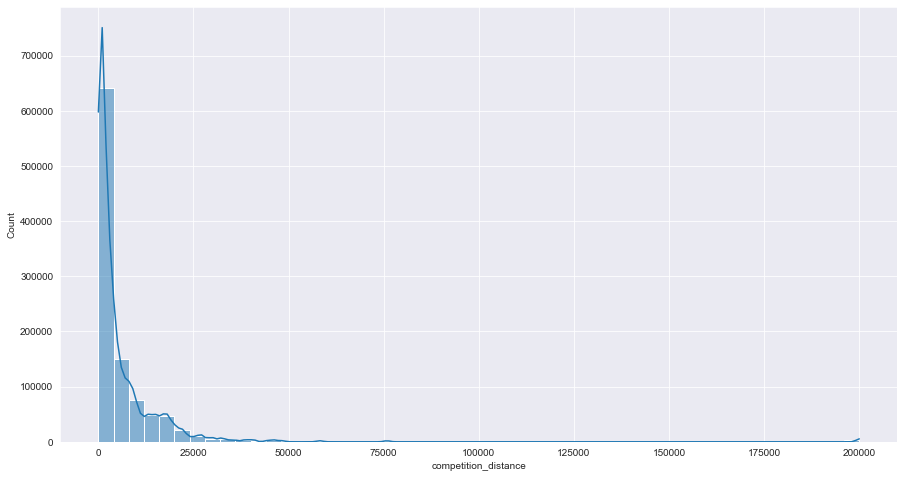

In [14]:
plt.figure( figsize=( 15, 8 ) )
sns.histplot( df1['competition_distance'], kde=True, bins=50, color=sns.color_palette('Paired')[1] )

### 1.7.2 Categorical Attributes

In [15]:
# unique values of each categorical feature
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Filtering the dataset, taking out the lines that contains the day when the store is closed (sales=0) and filtering by state_holiday (state_holiday=0 means that there isn't any state_holiday).

 - **StateHoliday**: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
 - **StoreType**:    differentiates between 4 different store models: a, b, c, d
 - **Assortment**:   describes an assortment level: a = basic, b = extra, c = extended
 
seing the graphs it's possible take some information such as:

 - The store type "b" has its median much higher than another one's and much outliers as well.
 - The state holiday are much similar among each other.

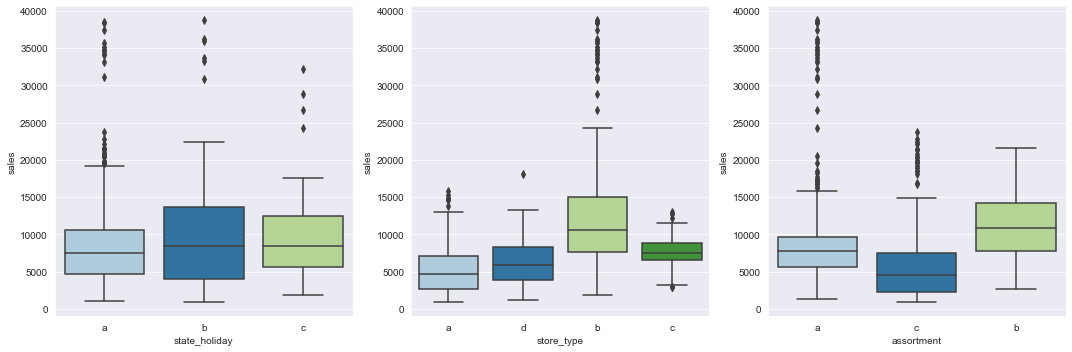

In [16]:
plt.figure( figsize=( 15, 5 ) )

aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] >0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

plt.tight_layout()

# 2.0 Feature Engineering

In [17]:
df2 = df1.copy()

## 2.1. MindMap Hypotesis

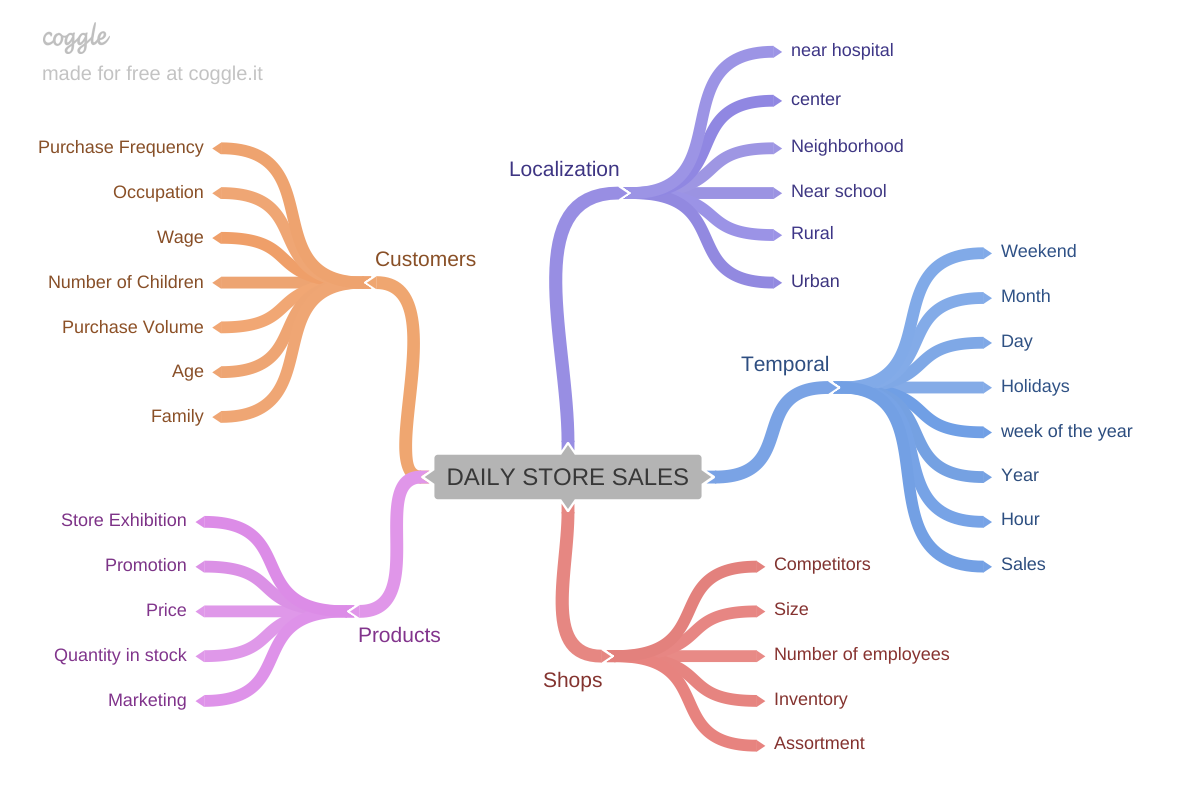

In [18]:
Image( 'img/DAILY_STORE_SALES_01.png' )

## 2.2. Creating Hypotheses

Creating Business Hypotheses that should be verified whether these Hypotheses are true or not. First I made a sub-list of some Hypotheses based on the agents "store", "product" and "time". After all, I propose a final Hypotheses list considering that a lot of hypotheses thought couldn't be answered because I have no information that makes me able to answer.

### 2.2.1 Store Hypotheses

**1.** Stores with more employees should sell more.

**2.** Stores with more inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less

**6.** Stores with longer-term competitors should sell more.

### 2.2.2 Products Hypotheses

**1.** Stores that invest more in marketing should sell more

**2.** Stores with greater product exposure should sell more

**3.** Stores that have lower prices on products should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with longer active promotions should sell more

**6.** Stores with more promotion days should sell more

**7.** Stores with more consecutive promotions should sell more

### 2.2.3 Time Hypotheses

**1.** Stores that open during the Christmas holiday should sell more

**2.** Stores should sell more over the years

**3.** Stores should sell more in the second half of the year

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

## 2.3. Final Hypotheses List

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less

**3.** Stores with longer-term competitors should sell more.

**4.** Stores with longer active promotions should sell more

**5.** Stores with more promotion days should sell more

**6.** Stores with more consecutive promotions should sell more

**7.** Stores open during the Christmas holiday should sell more

**8.** Stores should sell more over the years

**9.** Stores should sell more in the second half of the year

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays

## 2.4. Feature Engineering

In [19]:
# year
df2['year']  = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day']   = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( np.int64 )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-'+ df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( np.int64 )

# assortment
df2['assortment']    = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day' )

# 3.0. Filtering Varibles

Filter some variables that make sense to the business problem.

In [20]:
df3 = df2.copy()

In [21]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtering Rows

Filtering the dataset taking out the sales values higher than zero because when this variable is zero, means that the store is closed. And then filtering by the column 'open'  different of zero, because just is interested when the store is open.

In [22]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Filtering Columns

Filtering some features that are not accessible at the predict moment or restricted by the own business.

- **"customers"**: I don't know how many customers are going to be in the next weeks to make the prediction

- **"open"**: It was filtered before, and then just matter predict when the drug store is open. And all of the rows here are 1 (open).

- **"promo_interval"** and **"month_map"**: Used just as auxiliary or for derivate another feature.

In [23]:
columns_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop( columns_drop, axis=1 )

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EDA

In [24]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [25]:
num_attributes = df4.select_dtypes( include=['int64','float64'] )
cat_attributes = df4.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### 4.1.1. Response Variable

In [31]:
df4['sales'].describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: sales, dtype: float64

<AxesSubplot:xlabel='sales', ylabel='Count'>

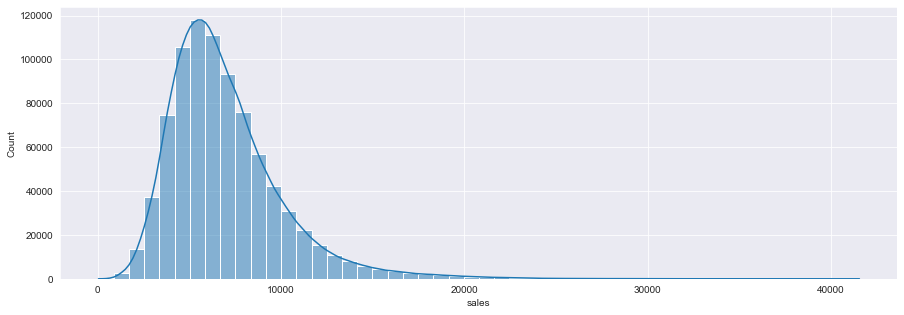

In [26]:
plt.figure( figsize=( 15, 5 ) )
sns.histplot( df4['sales'], kde=True, bins=50, color=sns.color_palette('Paired')[1] )

### 4.1.2. Numerical Variable

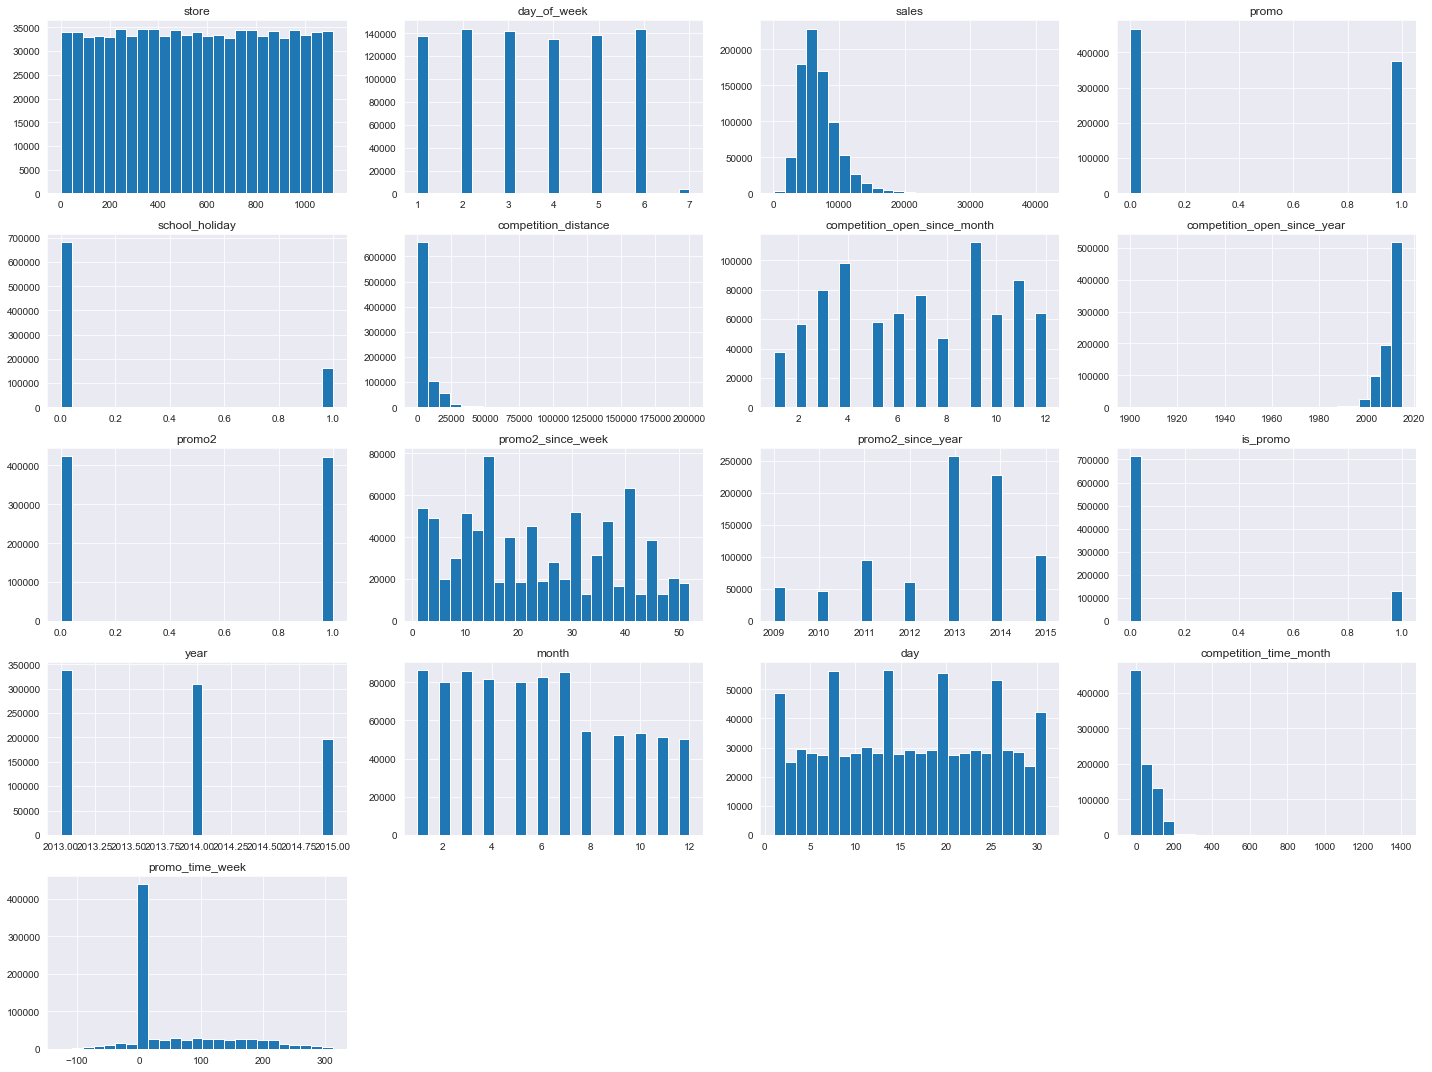

In [35]:
num_attributes.hist( bins =25, figsize=( 20, 15 ), color=sns.color_palette('Paired')[1] );

plt.tight_layout()

### 4.1.3. Categorical Variable

In [28]:
cat_attributes.head()

,state_holiday,store_type,assortment,week_of_year,year_week
0,regular_day,c,basic,31,2015-30
1,regular_day,a,basic,31,2015-30
2,regular_day,a,basic,31,2015-30
3,regular_day,c,extended,31,2015-30
4,regular_day,a,basic,31,2015-30


Filtering just the interested data

In [29]:
aux = df4[['state_holiday','store_type','assortment']]

for x in range( aux.shape[1] ):
    
    print( aux.iloc[:,x].name, '\n')
    print( aux.iloc[:,x].value_counts(), '\n' )

state_holiday 

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64 

store_type 

a    457042
d    258768
c    112968
b     15560
Name: store_type, dtype: int64 

assortment 

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64 



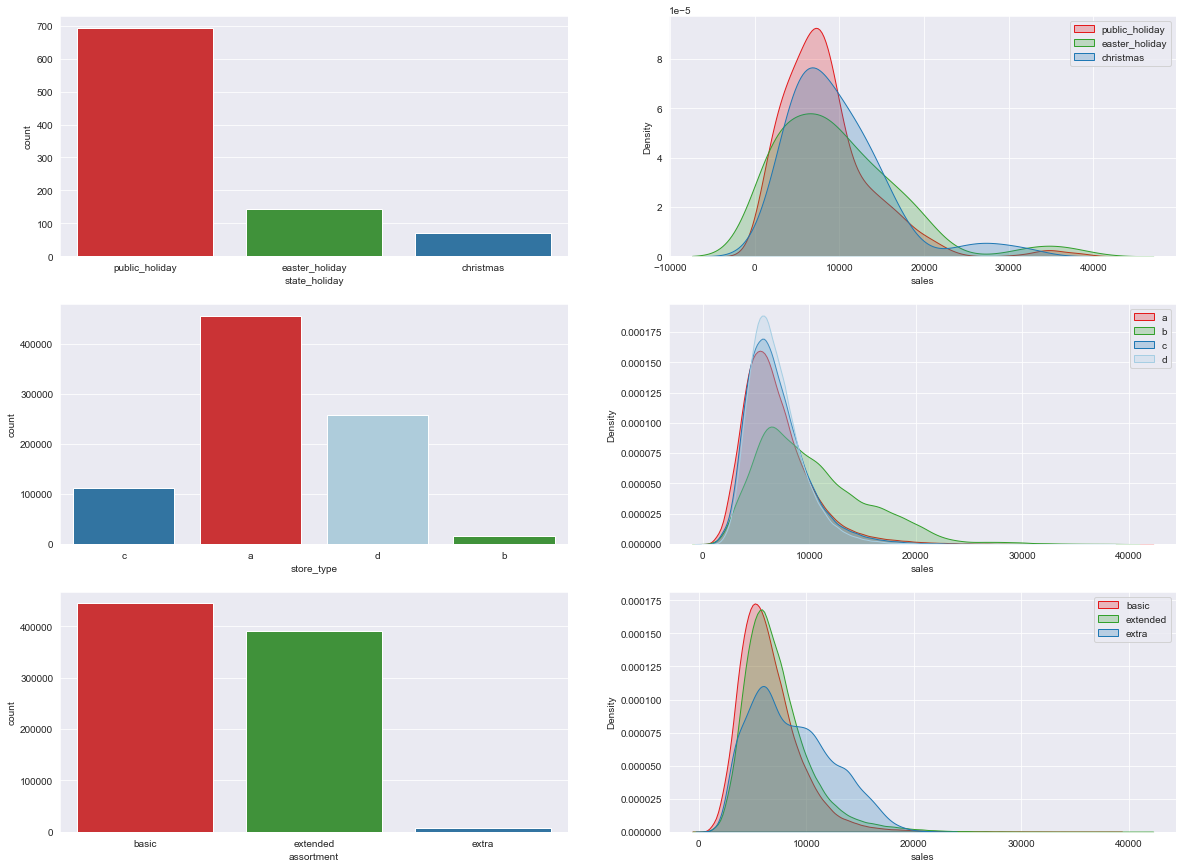

In [41]:
plt.figure( figsize=( 20, 15 ) )
#state_holiday

color = {'public_holiday': sns.color_palette('Paired')[5],
        'easter_holiday':  sns.color_palette('Paired')[3],
        'christmas':       sns.color_palette('Paired')[1]}

plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( data=a, x='state_holiday', palette=color )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['sales'], shade=True, label='public_holiday', color=sns.color_palette('Paired')[5] )
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['sales'], shade=True, label='easter_holiday', color=sns.color_palette('Paired')[3] )
sns.kdeplot( df4[ df4['state_holiday'] == 'christmas']['sales'], shade=True, label='christmas', color=sns.color_palette('Paired')[1] )

plt.legend()
#store_type
color = {'a': sns.color_palette('Paired')[5],
        'b':  sns.color_palette('Paired')[3],
        'c':  sns.color_palette('Paired')[1],
        'd':  sns.color_palette('Paired')[0]}

plt.subplot( 3, 2, 3)
sns.countplot( data=df4, x='store_type', palette=color )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], shade=True, label='a', color=sns.color_palette('Paired')[5] )
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], shade=True, label='b', color=sns.color_palette('Paired')[3] )
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], shade=True, label='c', color=sns.color_palette('Paired')[1] )
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], shade=True, label='d', color=sns.color_palette('Paired')[0] )

plt.legend()
#assortment
color = {'basic': sns.color_palette('Paired')[5],
        'extended':  sns.color_palette('Paired')[3],
        'extra':       sns.color_palette('Paired')[1]}

plt.subplot( 3, 2, 5)
sns.countplot( data=df4, x='assortment', palette=color )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['sales'], shade=True, label='basic', color=sns.color_palette('Paired')[5] )
sns.kdeplot( df4[ df4['assortment'] == 'extended']['sales'], shade=True, label='extended', color=sns.color_palette('Paired')[3] )
sns.kdeplot( df4[ df4['assortment'] == 'extra']['sales'], shade=True, label='extra', color=sns.color_palette('Paired')[1] )

plt.legend()

## 4.2. Bivariate Analysis

## 4.3. Multivariate Analysis